In [1]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.model_selection import LearningCurveDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
#from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# always have same random state across all code files
with open('random_state.txt') as f:
    random_state= int(f.readline())
    
print(random_state)

13


In [2]:
xgboost.__version__

'1.7.1'

## Prepare data

In [3]:
# load prepared dataset (encoded categorical data, no missing values)
diss = pd.read_csv("data/in_situ_data_for_regression.csv")
diss.columns

Index(['Depth', 'Source_abbrev', 'Latitude', 'Longitude', 'Sample', 'Material',
       'Organics', 'Device', 'PO4_cb', 'Deployment_d', 'Biogenic', 'Comments',
       'Mesh', 'Rate_mass', 'Size', 'Temp_woa', 'Sal_woa', 'TA_cb', 'DIC_cb',
       'Doxy_woa', 'Pressure', 'pH_insitu_cb', 'Omega_calc23', 'Omega_use',
       'Size_num', 'Deployment_d.1', 'Material_num', 'Device_num',
       'inorg_treated', 'Mesh.1', 'Method_num'],
      dtype='object')

In [4]:
# determine weights
studysize = {}
for s in diss["Source_abbrev"].unique():   
    studysize[s] = diss[diss["Source_abbrev"] == s]["Omega_calc23"].count()

#sample weight
weights = [max(studysize.values())/studysize[s] for s in diss["Source_abbrev"]]

In [5]:
# split data in test and training
feature_names = ["Omega_use", "Size_num", "Deployment_d", 'Material_num',
          "Device_num", "inorg_treated", "Mesh", 'Method_num']

X = diss[feature_names]
y = diss["Rate_mass"]

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, 
                                                                     weights, 
                                                                     train_size=0.8, 
                                                                     random_state=random_state,
                                                                     shuffle=True)
print(X_train.shape)
print(X_test.shape)

(463, 8)
(116, 8)


## Train model

In [6]:
# train with tuned parameters (see below where they were determined)
xgbr = xgboost.XGBRegressor(n_estimators=70, max_depth=6, objective="reg:squarederror", min_child_weight=6,
                                 reg_alpha=1, colsample_bytree=0.75, learning_rate=0.11, gamma=0,
                                 reg_lambda=9, random_state=random_state).fit(X_train, y_train, sample_weight=w_train)


# save model
xgbr.save_model("data/xgboost_regressor_dissolution_rate.json")

# performance on test set
y_pred = xgbr.predict(X_test)
print("R2 score          ", round(r2_score(y_test, y_pred, sample_weight=w_test),3))
print("RMSE              ", round(mean_squared_error(y_test, y_pred, squared=False, sample_weight=w_test),3))
print("Mean abs. err.    ", round(mean_absolute_error(y_test, y_pred, sample_weight=w_test),3))

R2 score           0.824
RMSE               0.079
Mean abs. err.     0.049


In [7]:
# comparison to training set
y_pred = xgbr.predict(X_train)
print("R2 score          ", round(r2_score(y_train, y_pred, sample_weight=w_train),3))
print("RMSE              ", round(mean_squared_error(y_train, y_pred, squared=False, sample_weight=w_train),3))
print("Mean abs. err.    ", round(mean_absolute_error(y_train, y_pred, sample_weight=w_train),3))

R2 score           0.847
RMSE               0.072
Mean abs. err.     0.033


## Learning curve (check model for over-/under-fitting) (Figure S15)

In [8]:
train_sizes = [1, 30, 100, 200, 300, 500]
X, y = shuffle(X, y, random_state=random_state)
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = xgbr,
    X = X,
    y = y, 
    train_sizes = train_sizes,
    cv = 10,
    scoring = 'neg_mean_squared_error',
    random_state = random_state,
    shuffle=True)


train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

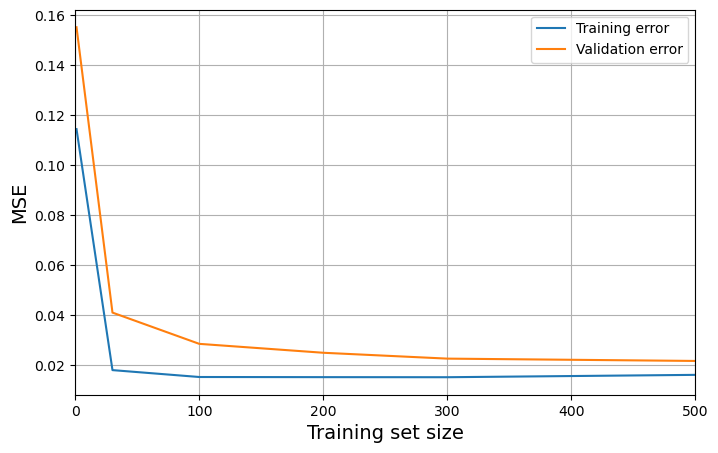

In [9]:
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
#plt.title('Learning curves for a linear regression model', fontsize = 14)
plt.legend()
plt.xlim(0,500)
plt.grid()
plt.show()
#plt.ylim(0,40)

# ------------------------------------------------------------------------

# Tune model (only once at beginning)
(more parameters were tested, it was narrowed down to this)

In [10]:
regressor = xgboost.XGBRegressor(objective="reg:squarederror")

parameters = {
    'n_estimators': [70, 80],
    "reg_alpha": [1, 2],
    'learning_rate': [0.1, 0.11, 0.12],
    "reg_lambda": [9,10,11],
    "gamma": [0,0.01],
    "max_depth": [6,7],
    "min_child_weight": [5,6,7],
    "colsample_bytree": [0.75, 0.8, 0.85]    
}


grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=parameters,
    scoring = 'r2',
    n_jobs = -1,
    cv = 5,
    verbose=True
)

grid_search.fit(X_train, y_train, sample_weight=w_train)



Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.75, 0.8, 0.85],
                         'gamma': [0, 0.01], 'learning_rate': [0.1, 0.11, 0.12],
                         'max_depth': [6, 7], 'min_child_weight': [5, 6, 7],
                         'n_estimators': [70, 80], 'reg_alpha': [1, 2],
                         'reg_lambda': [9, 10, 11]},
             scoring='r2', verbose=True)

In [11]:
# new
print("Best Parameters: \n{}\n".format(grid_search.best_params_))
print("Best Test Score: \n{}\n".format(grid_search.best_score_))

Best Parameters: 
{'colsample_bytree': 0.75, 'gamma': 0, 'learning_rate': 0.11, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 70, 'reg_alpha': 1, 'reg_lambda': 9}

Best Test Score: 
0.4752244447300578

